# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

# Setup
Watts 和 Strogatz 提出了用于构建小世界图的过程：
1.从一个正则图开始，节点为n，每个节点连接k个邻居。
2.选择边的子集，并将它们替换为随机的边来“重新布线”。
3.边的重新布线的概率是参数p，它控制图的随机性。当p = 0时，该图是正则的；p = 1是随机的。
4.Watts 和 Strogatz 发现，较小的p值产生高群聚性的图，如正则图，短路径长度的图，如随机图。

在本章中，我将按以下步骤复制 Watts 和 Strogatz 实验：
1.我们将从构建一个环格（ring lattice）开始，这是一种正则图。
2.然后我们和 Watts 和 Strogatz 一样重新布线。
3.我们将编写一个函数来测量群聚度，并使用 NetworkX 函数来计算路径长度。
4.然后，我们为范围内的p值计算群聚度和路径长度。
5.最后，我将介绍一种用于计算最短路径的高效算法，Dijkstra 算法。

In [294]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [295]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [296]:
# make a directory for figures
!mkdir -p figs

In [297]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

每个节点具有相同数量邻居
Subset of regular graph

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.
为了制作一个ring lattice，我将从一个生成器函数开始，它在每个节点和下一个“halfk”邻居之间产生边。

In [298]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [299]:
nodes = range(3)
for edge in adjacent_edges(nodes, 0):
    print(edge)

Now we use `adjacent_edges` to write `make_ring_lattice`

In [300]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [301]:
lattice = make_ring_lattice(10, 4)

Saving figure to file figs/chap03-1


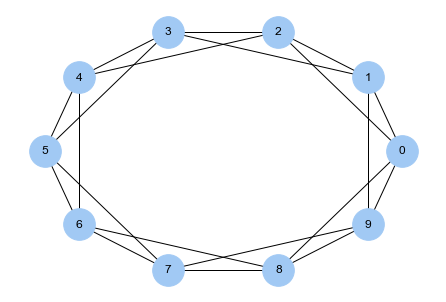

In [302]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

In [303]:
# Solution

lattice = make_ring_lattice(10, 5)

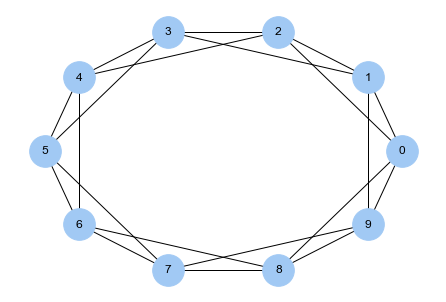

In [304]:
# Solution

nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

One of the exercises below asks you to explore regular graphs with odd values of `k`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.
在regular graph的基础上，每个节点都有概率与他的原始邻居断开并重新连接新的邻居，那么我们定义这个概率为P WS图的参数有:n个节点，k个邻居，P是概率。

In [305]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

To do the rewiring, we'll need `flip`.

In [306]:
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's the function that does the rewiring

In [307]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    # Fill this in

In [308]:
# Solution

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

Here's an example with `p=0.2`

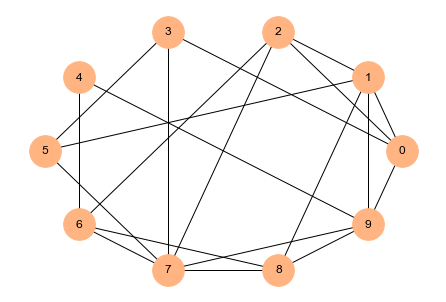

In [309]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [310]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`
当p = 0时，该图是 regualr ring lattice 。 当p = 1时，它是完全随机的。

Saving figure to file figs/chap03-2


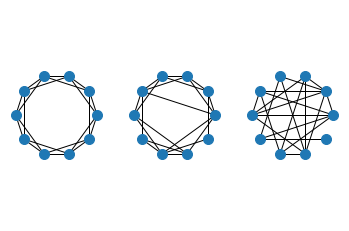

In [311]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

### Solution
The loop executes once for each edge.  Inside the loop, everything is constant
time except computing `choices`, which is linear in `n`.  So the total run time is 
`O(nm)`.
循环对每条边执行一次。在循环内部，一切都是不变的
除了计算 `choices` 之外的时间，它在 `n` 中是线性的。所以总运行时间是
`O(nm)`.

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:
 clustering coefficient for a given node, `u`节点的概率范围为(0,1):
 假设一个特定的节点u具有k个邻居。如果所有的邻居都相互连接，则会有k(k-1)/2个边。
如果我们计算所有节点上的$C{u}$平均值，我们得到“网络平均群聚系数”，表示为$\bar{c}$

In [312]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

In [313]:
def all_pairs(nodes):
    """Generates all pairs of nodes.
    生成所有节点对"""

    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [314]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.

    G: Graph

    returns: float
    """
    # FILL THIS IN
    return 0

In [315]:
# Solution

def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    局部聚类系数的平均值
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [316]:
lattice = make_ring_lattice(100, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [317]:
clustering_coefficient(lattice)

0.5

Correct.

In [318]:
%timeit clustering_coefficient(lattice)

252 µs ± 8.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [319]:
# Solution

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)

clustering_coefficient(lattice)

0.5

In [320]:
%timeit clustering_coefficient(lattice)

602 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

# Solution

"""`clustering_coefficient` calls `node_clustering` once for each node.  
`node_clustering` is quadratic in `k`, the number of neighbors.

In a complete graph, `k = n-1`, so `node_clustering` is `O(n^2)` and 
`clustering_coefficient` is `O(n^3)`.

But in a ring lattice, or any other graph where `k` is not proportional to `n`, 
`clustering_coefficient` is `O(k^2 n)`.
""";"""`clustering_coefficient`为每个节点调用一次`node_clustering`。
`node_clustering` 是 `k` 的二次方，即邻居的数量。

在一个完整的图中，`k = n-1`，所以 `node_clustering` 是 `O(n^2)` 并且
`clustering_coefficient` 是 `O(n^3)`。

但是在环形格子或任何其他“k”与“n”不成比例的图中，
`clustering_coefficient` 是 `O(k^2 n​​)`。
""";

## Path length

The following function computes path lengths between all pairs of nodes
以下函数计算所有节点对之间的路径长度

In [321]:
def path_lengths(G):
    # FILL THIS IN
    yield 0

In [322]:
# Solution

def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if source != dest:
                yield dist

The characteristic path length is the mean path length for all pairs.
特征路径长度是所有对的平均路径长度。

In [323]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1
在完全图上，平均路径长度应为 1

In [324]:
complete = nx.complete_graph(1000)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [325]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [326]:
# Solution


lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):
该函数使用给定的参数生成一个 WS 图并返回一对（平均路径长度，聚类系数）：
ws,mpl,cc
ws, mean path length, clustering coefficient

In [327]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [328]:
%time run_one_graph(1000, 10, 0.01)

8.286914914914915 0.6443376623376623
CPU times: user 834 ms, sys: 83.7 ms, total: 918 ms
Wall time: 957 ms


(8.286914914914915, 0.6443376623376623)

Now we'll run it with a range of values for `p`.
生成9个随机概率供后续使用

In [329]:
ps = np.logspace(start=-4, stop=0, num=9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` several times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.
该函数多次运行 `p` 的每个值并返回一个字典，该字典从每个 `p` 映射到 (mpl, cc) 对的列表。

In [330]:
def run_experiment(ps, n=1000, k=10, iters=10):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    10个用例
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

res是一个数组

In [331]:
%time res = run_experiment(ps)

0.0001
40.558644644644644 0.6664232323232322
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
42.54351351351352 0.6664232323232322
50.450450450450454 0.6666666666666665
47.28726326326326 0.6662787878787878
50.450450450450454 0.6666666666666665
49.82804004004004 0.66635101010101
40.110276276276274 0.6661343434343433
50.450450450450454 0.6666666666666665
[47.257999    0.66649439]
0.00031622776601683794
27.997943943943945 0.6656474747474747
35.00438238238238 0.6660353535353535
34.869533533533534 0.6661075757575756
40.47128128128128 0.6661343434343433
28.3858018018018 0.6648262626262625
32.83867067067067 0.665430808080808
26.27136136136136 0.6652595959595958
44.595467467467465 0.6657499999999998
50.450450450450454 0.6666666666666665
39.24145745745746 0.6662065656565656
[36.01263504  0.66580646]
0.001
25.31946146146146 0.6642671717171716
23.974042042042043 0.6644570707070707
26.606564564564565 0.6650469696969696
27.64162162162162 0.6647994949494949
27.771625625625

Here are the raw results.  Warning: this takes a few minutes to run.

In [332]:
res

array([[4.72579990e+01, 6.66494394e-01],
       [3.60126350e+01, 6.65806465e-01],
       [2.47578789e+01, 6.64321364e-01],
       [1.48735536e+01, 6.60078492e-01],
       [8.90577077e+00, 6.47237771e-01],
       [6.02526667e+00, 6.09418539e-01],
       [4.42338298e+00, 4.90675766e-01],
       [3.57842623e+00, 2.17958431e-01],
       [3.26871271e+00, 9.44090314e-03]])

Let's get the results into a form that's easy to plot.

In [333]:
L, C = np.transpose(res)

In [334]:
L

array([47.257999  , 36.01263504, 24.75787888, 14.87355355,  8.90577077,
        6.02526667,  4.42338298,  3.57842623,  3.26871271])

In [335]:
C

array([0.66649439, 0.66580646, 0.66432136, 0.66007849, 0.64723777,
       0.60941854, 0.49067577, 0.21795843, 0.0094409 ])

And normalize them so they both start at 1.0
L[0]代表路径长度的第一个, C[0]代表群聚系数第一

In [336]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

Saving figure to file figs/chap03-3


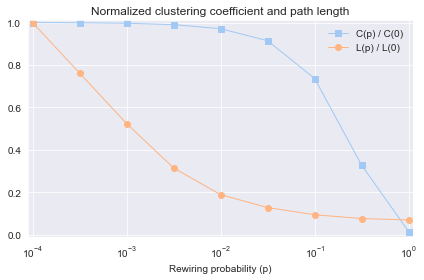

In [337]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

shows the results. As p increases, the mean path length drops quickly, because even a small number of randomly rewired edges provide shortcuts between regions of the graph that are far apart in the lattice. On the other hand, removing local links decreases the clustering coefficient much more slowly.

As a result, there is a wide range of p where a WS graph has the properties of a small world graph, high clustering and low path lengths.

And that’s why Watts and Strogatz propose WS graphs as a model for real-world networks that exhibit the small world phenomenon.
随着p的增加，平均路径长度迅速下降，因为即使少量随机重新布线的边，也提供了图区域之间的捷径，它们在格中相距很远。另一方面，删除局部链接降低了群聚系数，但是要慢得多。

因此，存在较宽范围的p，其中 WS 图具有小世界图的性质，高群聚度和短路径长度。

这就是为什么 Watts 和 Strogatz 提出了 WS 图，作为展示小世界现象的，现实世界网络的模型。

## Breadth-first search
广度优先搜索BFS

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:
现在让我们看看最短路径算法是如何工作的。我们将从 BFS 开始，这是 Dijkstra 算法的基础。

这是我们的老朋友，ring lattice：

In [338]:
lattice = make_ring_lattice(10, 4)

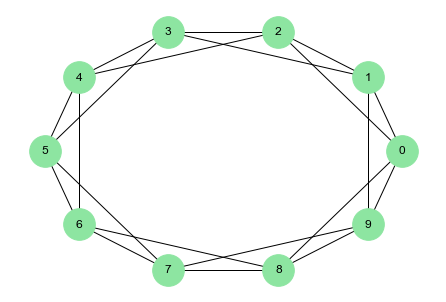

In [339]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.
reachable_nodes的作用是:
它寻找从给定的起始节点可以到达的所有节点：

In [340]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [373]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

堆栈的长度O(n)，这使得 BFS 的O(nm)的实现比O(n + m)差得多
我们可以用双向队列（也称为deque）来解决这个问题。deque的一个重要特征就是，你可以在开头和末尾添加和删除元素
我用名为queue的deque替换了名为stack的列表。
我用popleft替换pop，它删除并返回队列的最左边的元素，这是第一个添加的元素。
这个版本恢复为O(n + m)。现在我们做好了寻找最短路径的准备。

这是一个更快的版本。
差异在于：

我用名为queue的deque替换了名为stack的列表。
我用popleft替换pop，它删除并返回队列的最左边的元素，这是第一个添加的元素。
这个版本恢复为O(n + m)。现在我们做好了寻找最短路径的准备。

In [342]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [343]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.
现在我们已经为 Dijkstra 算法做好了准备，至少对于所有边都具有相同权重/长度的图。
简化版本，所有边的长度相同
这是它的工作原理：

最初，队列包含单个元素start，dist将start映射为距离 0（这是start到自身的距离）。
每次循环中，我们使用popleft获取节点，按照添加到队列的顺序。
接下来，我们发现节点的所有邻居都没有在dist中。
由于从起点到节点的距离是dist [node]，到任何未访问的邻居的距离是dist [node] +1。
对于每个邻居，我们向dist添加一个条目，然后将邻居添加到队列中。
shortest_path_dijkstra(G图, source起始点)

In [344]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [345]:
lattice = make_ring_lattice(10, 4)

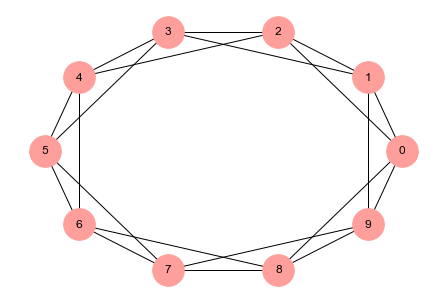

In [346]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [347]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [348]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [349]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.
在 `n=1000` 和 `k=10` 的环格中，哪个节点离 0 最远，距离多远？使用 `shortest_path_dijkstra` 检查你的答案。

注意：两个节点之间的最大距离是图形的**直径**。


In [350]:
# Solution


lattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra(lattice, 0)
for node, dist in d.items():
    print(node, dist)
    break

0 0


In [374]:
# Solution

func = lambda item: item[1]
node, dist = max(d.items(), key=func)
node, dist

(496, 100)

In [352]:
# Solution

d[495], d[496], d[497], d[498], d[499], d[500], d[501], d[502], d[503], d[504], d[505], 

(99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 99)

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.
**练习：** 在环格中，每个节点都有相同数量的邻居。邻居的数量称为节点的**度**，所有节点具有相同度数的图称为**正则图**。

所有环格都是正则的，但并非所有正则图都是环格。特别是，如果“k”是奇数，我们不能构造一个环格，但我们可以构造一个正则图。

编写一个名为“make_regular_graph”的函数，它接受“n”和“k”并返回一个包含“n”个节点的正则图，其中每个节点都有“k”个邻居。如果无法使用给定的 `n` 和 `k` 值制作规则图，则该函数应引发 `ValueError`。
n和k不能同时是奇数

In [353]:
# Here's `adjacent_edges` again for comparison:

def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [354]:
# Solution

# And here's a function that computes edges that connect each
# node to the one half-way around the circle

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

In [355]:
# Solution

# Now we can make regular graphs.

def make_regular_graph(n, k):
    """Makes graph with `n` nodes where all nodes have `k` neighbors.
    
    Not possible if both `n` and `k` are odd.
    """
    # a is the number of adjacent edges
    # b is the number of opposite edges (0 or 1)
    a, b = divmod(k, 2)
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    # if k is odd, add opposite edges
    if b:
        if n%2:
            msg = "Can't make a regular graph if n and k are odd."
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G

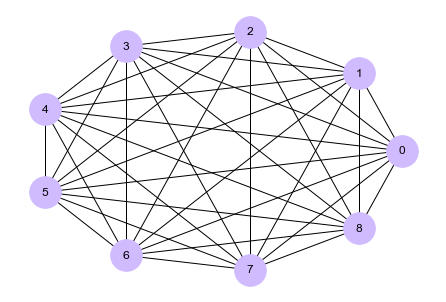

In [356]:
# Solution

# Here's an example.

regular = make_regular_graph(9, 8)

nx.draw_circular(regular, 
                 node_color='C4', 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:
练习：我的reachable_nodes_bfs 的实现在它位于的意义上是有效的，但是它会产生大量开销，将节点添加到队列中并删除它们。 NetworkX 提供了一个简单、快速的 BFS 实现，可从 GitHub 上的 NetworkX 存储库获得。
这是我修改为返回一组节点的版本：
plain_bfs(G图, start起始节点):

In [357]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`
将此函数与reachable_nodes_bfs 进行比较，看看哪个更快。然后看看能不能修改这个函数来实现更快的shortest_path_dijkstra版本

In [358]:
# Solution

lattice = make_ring_lattice(1000, 10)

In [359]:
# Solution

%timeit len(reachable_nodes_bfs(lattice, 0))

874 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [360]:
# Solution

%timeit len(plain_bfs(lattice, 0))

561 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Solution

#The version from NetworkX is faster.

#Here's a version of Dijkstra's algorithm that works the same way:

In [361]:


def plain_shortest_path(G, source):
    """A fast version of Dijkstra's algorithm for equal edges."""
    new_dist = 0
    dist = {}
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in dist:
                dist[v] = new_dist
                nextlevel.update(G[v])
        new_dist += 1
    return dist

In [375]:
# Solution

#It gets the right answers

lattice = make_ring_lattice(1000, 10)
d1 = shortest_path_dijkstra(lattice, 0)
d2 = plain_shortest_path(lattice, 0)
d3 = nx.shortest_path_length(lattice, 0)
d1 == d2 == d3

True

In [376]:
# Solution

# And it is faster than the version that uses a deque.

%timeit shortest_path_dijkstra(lattice, 0)

747 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [377]:
# Solution

%timeit plain_shortest_path(lattice, 0)

549 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [378]:
# Solution

%timeit nx.shortest_path_length(lattice, 0)

575 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?
练习：以下 BFS 实现包含两个性能错误。这些是什么？这个算法的实际增长顺序是什么？

In [366]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

# Solution

The first performance error is using `pop(0)` on a list, which is linear in
the length of the list.
The second error is checking whether the children are
in queue, which is also linear in the length of the list.
In the worst case,
a completely connected graph, the queue loop runs `n` times, and each time we 
have to check `n` nodes to see if they are in a list with `n` elements, so the 
total run time is `O(n^3)`, which is really terrible.

By the way, I did not make this example up.  It used to be on 
[the Wikipedia page for BFS](https://en.wikipedia.org/wiki/Breadth-first_search).
In fact, if you search the Internet for Python implementations of BFS, many of 
them contain at least one performance error.

第一个性能错误是在列表上使用 `pop(0)`，它是线性的
列表的长度。
第二个错误是检查孩子是否在队列中，这在列表的长度上也是线性的。
在最坏的情况下，一个完全连通的图，队列循环运行`n`次，每次我们必须检查 n 节点以查看它们是否在具有 n 元素的列表中，因此
总运行时间是 `O(n^3)`，这真的很糟糕。

顺便说一句，我没有编造这个例子。
[BFS 的维基百科页面](https://en.wikipedia.org/wiki/Breadth-first_search)。
事实上，如果你在 Internet 上搜索 BFS 的 Python 实现，很多
它们至少包含一个性能错误。

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [367]:
# Solution

# Here's the broken version:

def shortest_path_dfs(G, start):
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

#Sure enough, it gets the answers wrong

lattice = make_ring_lattice(10, 4)
d1 = shortest_path_dfs(lattice, 0)
print(d1)
d2 = nx.shortest_path_length(lattice, 0)
print(d2)
d1 == d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 7: 2, 5: 3, 6: 3, 4: 4, 3: 5}
{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}


False